In [ ]:
!pip3 install --upgrade pip
!pip3 install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 594.4 kB/s eta 0:00:00


In [ ]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [ ]:
no_train = False
fashion = True
batch_size = 128
n_epochs = 20
lr = 0.001

In [ ]:
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

In [ ]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [ ]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

In [ ]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



<ipython-input-5-41ca7b27e20f>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(rows, cols, idx + 1)


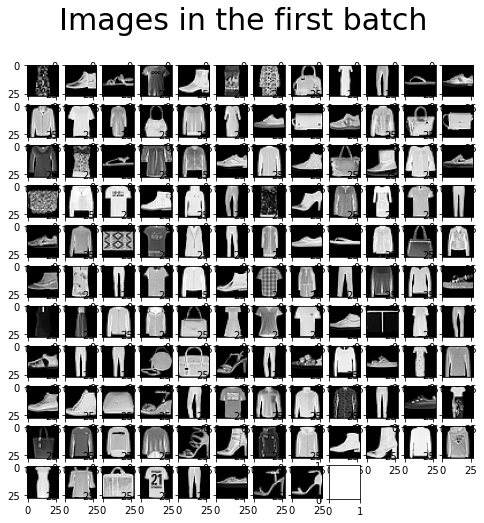

In [ ]:
# Optionally, show a batch of regular images
show_first_batch(loader)

In [ ]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla T4


In [ ]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [ ]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [ ]:
def generate_new_images(ddpm, n_samples=16, device=None, c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z
    return x

In [ ]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [ ]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [ ]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [ ]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [ ]:
sum([p.numel() for p in ddpm.parameters()])

606852

In [ ]:
# ddpm.load_state_dict(torch.load(store_path, map_location=device))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


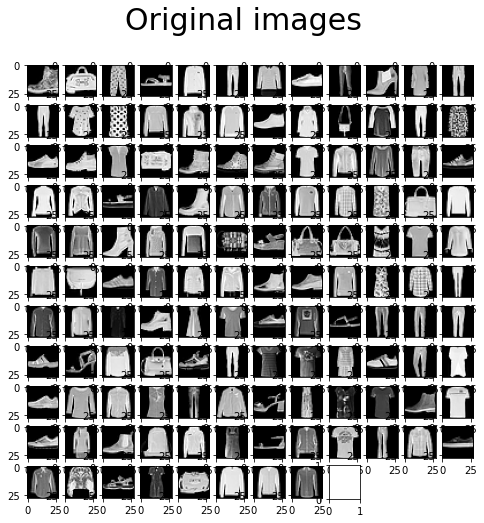

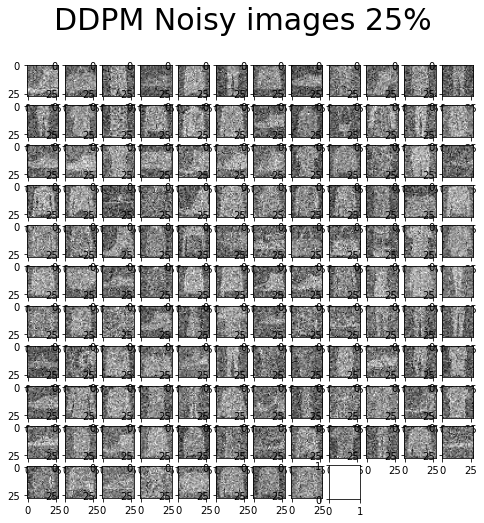

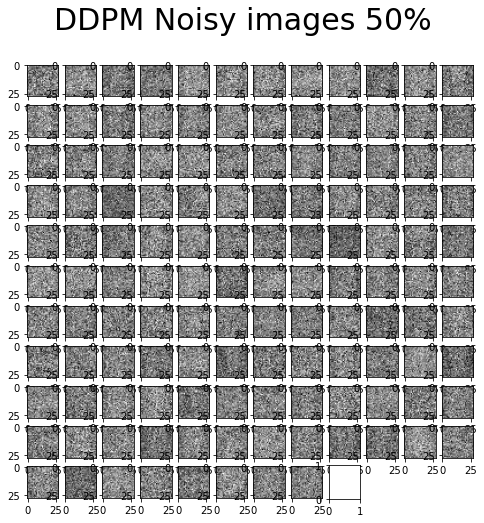

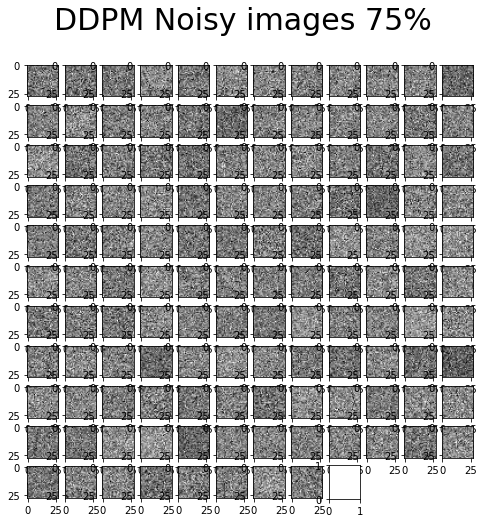

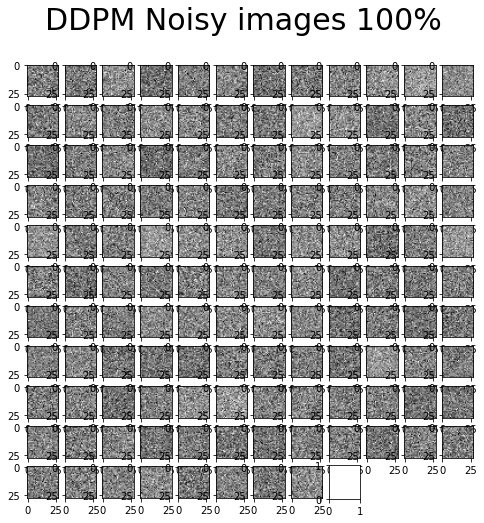

In [ ]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, loader, device)

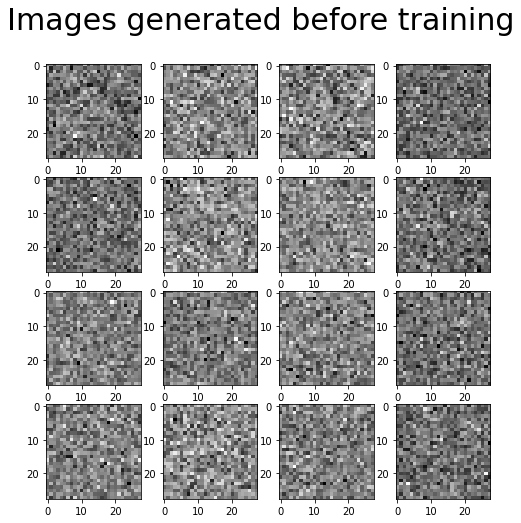

In [ ]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

In [ ]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [ ]:
# Training
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"
if not no_train:
    training_loop(ddpm, loader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 1: 0.206 --> Best model ever (stored)


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 2: 0.081 --> Best model ever (stored)


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 3: 0.070 --> Best model ever (stored)


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 4: 0.065 --> Best model ever (stored)


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 5: 0.062 --> Best model ever (stored)


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 6: 0.058 --> Best model ever (stored)


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 7: 0.057 --> Best model ever (stored)


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 8: 0.056 --> Best model ever (stored)


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 9: 0.055 --> Best model ever (stored)


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 10: 0.054 --> Best model ever (stored)


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 11: 0.052 --> Best model ever (stored)


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 12: 0.052 --> Best model ever (stored)


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 13: 0.053


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 14: 0.051 --> Best model ever (stored)


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 15: 0.051 --> Best model ever (stored)


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 16: 0.050 --> Best model ever (stored)


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 17: 0.050


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 18: 0.050 --> Best model ever (stored)


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 19: 0.049 --> Best model ever (stored)


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 20: 0.049 --> Best model ever (stored)


In [ ]:
# Loading the trained model
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded: Generating new images")

Model loaded: Generating new images


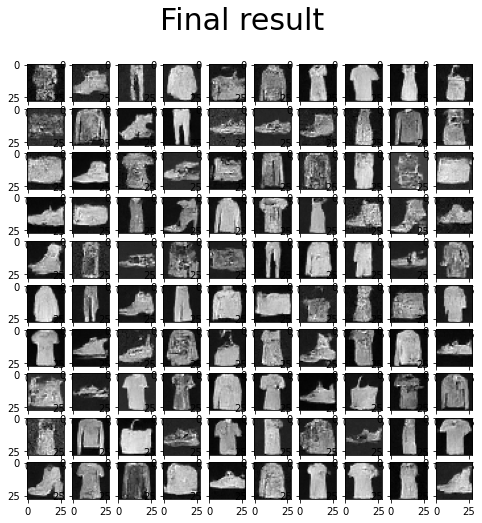

In [ ]:
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")